Finding Periodic Orbits
=========================

In this example, we will show how it is possible to use heyoka.py's [expression system](<./The expression system.ipynb>), to compute the state transition matrix of the [circular restricted three-body problem](<./The restricted three-body problem.ipynb>) via [variational equations](<./The variational equations.ipynb>) and outline its use to find periodic orbits. 

We make some standard imports:

In [1]:
import heyoka as hy
import numpy as np
import time 

from scipy.optimize import root_scalar

from matplotlib.pylab import plt

... and define some functions that will help later on to visualize our trajectories and make nice plots. (ignore them and come back to this later in case you are curious)

In [2]:
def compute_L_points(mu, f):
    """Computes The exact position of the Lagrangian points. To do so it finds the zeros of the
    the dynamics equation for px.
    
        Args:
            mu (float): The value of the mu parameter.
            f (heyoka expression): The px dynamics equation.

        Returns:
            xL1, xL2, xL3, xL45, yL45: The coordinates of the various Lagrangian Points
    """
    # Position of the lagrangian points approximated
    xL1 = (mu-1) + (mu/3/(1-mu))**(1/3)
    xL2 = (mu-1) - (mu/3/(1-mu))**(1/3)
    xL3 = -(mu-1) - 7/12 * mu / (1-mu)
    yL45 = np.sin(60/180*np.pi)
    xL45 = -0.5 + mu

    # Solve for the static equilibrium from the approximated solution
    def equilibrium(expr, x,y):
        retval = hy.eval(expr, {"x":x, "y":y, "z":0, "px":-y, "py":x, "pz":0}, [mu])
        return retval
    xL1 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL1,x1=xL1-1e-2).root
    xL2 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL2,x1=xL2-1e-2).root
    xL3 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL3,x1=xL3-1e-2).root;
    return xL1, xL2, xL3, xL45, yL45

def potential_function(position,mu):
    """Computes the system potential
        Args:
            position (array-like): The position in Cartesian coordinates
            mu (float): The value of the mu parameter.

        Returns:
            The potential
    """
    x,y,z=position
    r_1=np.sqrt((x-mu)**2+y**2+z**2)
    r_2=np.sqrt((x-mu+1)**2+y**2+z**2)
    Omega=1./2.*(x**2+y**2)+(1-mu)/r_1+mu/r_2
    return Omega

def jacobi_constant(state,mu):
    """Computes the system Jacobi constant
        Args:
            state (array-like): The system state (x,y,z,px,py,pz)
            mu (float): The value of the mu parameter.

        Returns:
            The Jacobi constant for the state
    """
    x,y,z,px,py,pz=state
    vx = px + y
    vy = py - x
    vz = pz
    r_1=np.sqrt((x-mu)**2+y**2+z**2)
    r_2=np.sqrt((x-mu+1)**2+y**2+z**2)
    Omega=1/2*(x**2+y**2)+(1-mu)/r_1+mu/r_2
    T=1/2*(vx**2+vy**2+vz**2)
    C=Omega-T
    return C

## The Circular Restricted 3 Body Problem dynamics

Let us start defining the equations of motion for the Circular Restricted 3 Body Problem (CR3BP from now on). 

The problem is usually formulated in a rotating reference frame in which the two massive bodies are at rest. In the rotating reference frame, the equations of motion for the massless particle's cartesian coordinates $\left(x, y, z\right)$ and conjugated momenta $\left(p_x, p_y, p_z\right)$ read:

$$
\begin{aligned}
\dot{x} & = p_x+y,\\
\dot{y} & = p_y-x, \\
\dot{z} & = p_z, \\
\dot{p}_x & = p_y - \frac{1-\mu}{r_{PS}^3}\left( x - \mu \right)-\frac{\mu}{r_{PJ}^3}\left( x - \mu + 1\right), \\
\dot{p}_y & = -p_x-\left( \frac{1-\mu}{r_{PS}^3} +  \frac{\mu}{r_{PJ}^3}\right)y, \\
\dot{p}_z & = -\left( \frac{1-\mu}{r_{PS}^3} +  \frac{\mu}{r_{PJ}^3}\right)z,
\end{aligned}
$$

where $\mu$ is a mass parameter, $r_{PS}^2=\left( x-\mu \right)^2+y^2+z^2$ and $r_{PJ}^2=\left( x -\mu + 1 \right)^2+y^2+z^2$. 

NOTE: In these equations it is assumed that $M_1 + M_2 = 1$ and the Cavendish constant $G=1$. The biggest mass is then indicated with $1-\mu$, while the smallest with $\mu$. The biggest mass is placed in $x = \mu$ and the smallest in $x = \mu-1$ so that the distance between primaries is also 1. All remaining units are induced by these choices.

We also refer to the whole state with the symbol $\mathbf x = [x,y,z,p_x, p_y, p_z]$ and the right hand side of the dynamic equations with the symbol $\mathbf f$. In general we use bold for vectors matrices and normal fonts for their components, hence $\mathbf M$ will, as an example, have components $M_{ij}$.

With respect to the heyoka.py notebook on [circular restricted three-body problem](<./The restricted three-body problem.ipynb>), we will be here making use of numpy arrays of heyoka expressions as to simplify the notation later on when we need to compute the variational equations.

In [3]:
# Create the symbolic variables.
symbols_state = ["x", "y", "z", "px", "py", "pz"]
x = np.array(hy.make_vars(*symbols_state))
# This will contain the r.h.s. of the equations
f = []

rps_32 = ((x[0] - hy.par[0])**2 + x[1]**2 + x[2]**2)**(-3/2.)
rpj_32 = ((x[0] - hy.par[0]  + 1.)**2 + x[1]**2 + x[2]**2)**(-3/2.)

# The equations of motion.
f.append(x[3] + x[1])
f.append(x[4] - x[0])
f.append(x[5])
f.append(x[4] - (1. - hy.par[0]) * rps_32 * (x[0] - hy.par[0]) - hy.par[0] * rpj_32 * (x[0] - hy.par[0] + 1.))
f.append(-x[3] -((1. - hy.par[0]) * rps_32 + hy.par[0] * rpj_32) * x[1])
f.append(-((1. - hy.par[0]) * rps_32 + hy.par[0] * rpj_32) * x[2])
f = np.array(f)

## The variational equations

We now compute the variational equations expressing the state transition matrix defined as $\delta \mathbf x(t) = \mathbf \Phi(t)\delta \mathbf x(0)$. We define its $ij$ component as:
$$
\Phi_{ij}(t) = \frac{d x_i(t)}{dx_j(0)}
$$
hence the variational equations:
$$
\frac{d }{dt} \Phi_{ij}(t) = \frac{d}{dt}\left(\frac{d x_i(t)}{dx_j(0)}\right) = \frac{d}{dx_j(0)}\left(\frac{d x_i(t)}{dt}\right) = \frac{d f_i(x(t))}{dx_j(0)}
$$
expanding the total derivative in the last term we get:
$$
\frac{d}{dt}\Phi_{ij}(t) = \sum_k \frac{\partial f_i}{\partial x_k}\frac{dx_k(t)}{dx_j(0)}=\sum_k \frac{\partial f_i}{\partial x_k} \Phi_{kj}(t)
$$
which can be written in compact matrix form as:
$$
\frac{d}{dt}\mathbf \Phi(t) = \left[\frac{\partial f_i}{\partial x_k}\right] \mathbf \Phi(t)
$$
Note that the initial conditions are, trivially: $\mathbf \Phi(0) = \mathbf I$

Let us then introduce these variational equations using heyoka.

First, we define the various symbols for the components of the state transition matrix

In [4]:
symbols_phi = []
for i in range(6):
    for j in range(6):
        # Here we define the symbol for the variations
        symbols_phi.append("phi_"+str(i)+str(j))  
phi = np.array(hy.make_vars(*symbols_phi)).reshape((6,6))

Then we find the various $\left[\frac{\partial f_i}{\partial x_k}\right]$:

In [5]:
dfdx = []
for i in range(6):
    for j in range(6):
        dfdx.append(hy.diff(f[i],x[j]))
dfdx = np.array(dfdx).reshape((6,6))

... and finally the r.h.s. of the variational equations is:

In [6]:
# The (variational) equations of motion
dphidt = dfdx@phi

how very very beautiful!

## Putting all together and integrating some initial conditions
Let us put all the equations 6 + 6x6 = 42 into one big Taylor integrator and perform one numerical integration.

In [7]:
# We create the dynamics
dyn = []
for state, rhs in zip(x,f):
    dyn.append((state, rhs))
for state, rhs in zip(phi.reshape((36,)),dphidt.reshape((36,))):
    dyn.append((state, rhs))
# These are the initial conditions on the variational equations (the identity matrix)
ic_var = np.eye(6).reshape((36,)).tolist()

In [8]:
#  We instantiate the Taylor integrator (high accuracy and no compact mode)
start_time = time.time()
ta = hy.taylor_adaptive(
    # The ODEs.
    dyn,
    # The initial conditions.
    [-0.45, 0.80, 0.00, -0.80, -0.45, 0.58] + ic_var,
    # Operate below machine precision
    # and in high-accuracy mode.
    tol = 1e-18, high_accuracy = True
)
print("--- %s seconds --- to build the Taylor integrator" % (time.time() - start_time))

--- 9.48668885231018 seconds --- to build the Taylor integrator


In [9]:
# We perform and time a numerical propagation for these conditions
ic = [-0.80, 0.0, 0, 0.0, -0.6276410653920693, 0.]
t_final=200
mu=0.01
ta.pars[0] = mu
# Reset the state
ta.time = 0
ta.state[:] = ic + ic_var
# Time grid
t_grid = np.linspace(0, t_final, 2000)
# Go ...
start_time = time.time()
out = ta.propagate_grid(t_grid)
print("--- %s seconds --- to propagate" % (time.time() - start_time))

--- 0.054412841796875 seconds --- to propagate


... let us then plot the trajectory and some further cosmetics to visualize the solution

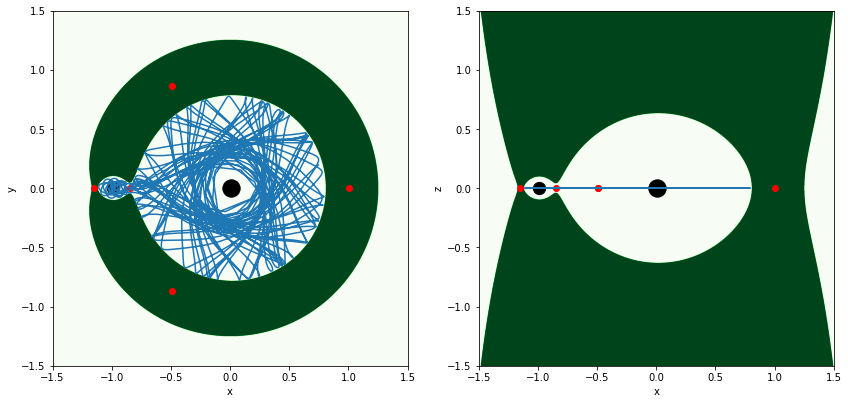

In [10]:
plt.figure(figsize=(14,14))

# Lets find the postiion of the lagrangian points
xL1, xL2, xL3, xL45, yL45 = compute_L_points(mu, f[3])
# We also compute the Jacobi constant
C_jacobi = jacobi_constant(ic, mu)

# Plot the trajectory (xy)
plt.subplot(1,2,1)
plt.plot(out[4][:, 0], out[4][:, 1])
plt.xlabel("x")
plt.ylabel("y")
# Plot the zero velocity curve
xx = np.linspace(-1.5,1.5,2000)
yy = np.linspace(-1.5,1.5,2000)
x_grid,y_grid = np.meshgrid(xx,yy)
im = plt.imshow( ((potential_function((x_grid,y_grid,np.zeros(np.shape(x_grid))),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),y_grid.min(),y_grid.max()),origin="lower", cmap="Greens")
# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=150)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, yL45, c='r')
plt.scatter(-0.5+mu, -yL45, c='r')

# Plot the trajectory (xz)
plt.subplot(1,2,2)
plt.plot(out[4][:, 0], out[4][:, 2])
plt.xlabel("x")
plt.ylabel("z");
# Plot the zero velocity curve
xx = np.linspace(-1.5,1.5,2000)
zz = np.linspace(-1.5,1.5,2000)
x_grid,z_grid = np.meshgrid(xx,zz)
im = plt.imshow( ((potential_function((x_grid,np.zeros(np.shape(x_grid)), z_grid),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),z_grid.min(),z_grid.max()),origin="lower", cmap="Greens")
# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=150)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, 0, c='r')
plt.scatter(-0.5+mu, 0, c='r')

## Finding Periodic Orbits
To find a periodic orbit in a dynamical system, a first step to then possibly find a whole family of them, we will proceed as follows:

* Get some initial conditions by trial and error, else one can use the [Poincaré–Lindstedt method](https://en.wikipedia.org/wiki/Poincar%C3%A9%E2%80%93Lindstedt_method) or, in the specific case of the CR3BP, the work from Richardson).

Richardson, D. L. (1980). Analytic construction of periodic orbits about the collinear points. Celestial mechanics, 22(3), 241-253.

* Once some initial guess $\mathbf x_0$ is available for the initial state an $T$ for the period, we may write the Taylor first order expansion of the system solution as:

$$
\mathbf x = \overline {\mathbf x} + \mathbf \Phi \delta \mathbf x_0 + \mathbf \Phi_T \delta T
$$

where $\mathbf \Phi = \left[\frac{\partial x_i}{\partial x_{0_k}}\right] $ is computed via the variational equations, $\mathbf \Phi_T = \left[\frac{\partial x_i}{\partial t}\right] = \dot{\mathbf x}$ and $\overline {\mathbf x}$ is the final state reached starting from $\mathbf x_0$ and integrating for $T$.

* Now (**pay attention, as here is the whole trick**), we write the periodicity condition enforcing that after $T+\delta T$ the state will go back to $\mathbf x_0 + \delta \mathbf x_0$:

$$
\overline {\mathbf x} + \mathbf \Phi \delta \mathbf x_0 + \mathbf \Phi_T \delta T = \mathbf x_0 + \delta \mathbf x_0
$$

which is rearranged in the form:

$$
\left(\mathbf \Phi -\mathbf I\right) \delta \mathbf x_0 + \mathbf \Phi_T \delta T = \mathbf x_0 -\overline {\mathbf x}
$$

This fundamental relation is at the basis of any numerical algorithm that wants to find a closed periodic orbit. It is a system of 6 equation in the 7 unknowns $\mathbf x, T$ (as a consequence, it is overdetermined). Furthermore, the matrix $\mathbf \Phi-\mathbf I$ is ill conditioned as $\mathbf \Phi$ will admit the eigenvalue 1 when the orbit is periodic (that is when the algorithm converges and $\mathbf \Phi$ approaches a monodromy matrix).

Let us implement a naive iterative scheme that closes some orbit. We will make the above system square by fixing the $x_0$ value (arbitrary decision, albeit clever in this specific case), and we will ignore the problem of the matrix $\mathbf \Phi - \mathbf I$ tending to a singular matrix.

So, first we play to find a decent initial condition ....

In [11]:
# New mu parameter (no reason to change, just came out playing)
mu = 0.01215057
# Initial guess for the integration time (will eventually converge to a period)
t_final = 3.
# We recomupte the lagrangian points
xL1, xL2, xL3, xL45, yL45 = compute_L_points(mu, f[3])

# Initial conditions in the cartesian representation x,y,z,vx,vy,vz
ic_cart = [ -8.36809444e-01, 0.,0.,0.,  -8.85435468e-04, 0.]
ic = [ic_cart[0], ic_cart[1], ic_cart[2], ic_cart[3]- ic_cart[1], ic_cart[4] + ic_cart[0], ic_cart[5]]
# We recompute  the Jacobi constant
C_jacobi = jacobi_constant(ic, mu)

# Reset the state
ta.time = 0.
ta.state[:] = ic + ic_var
ta.pars[0] = mu
# Time grid
t_grid = np.linspace(0, t_final, 2000)
# Go ...
out = ta.propagate_grid(t_grid)

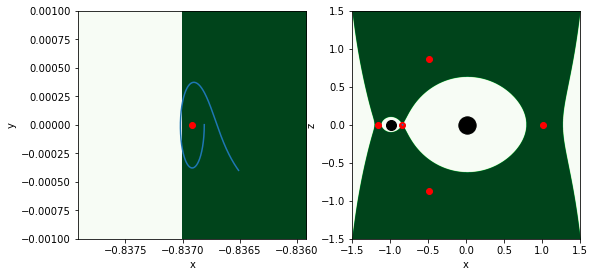

In [12]:
# We plot the initial condition (zoom in the Lagrangian point)
plt.figure(figsize=(9,9))

plt.subplot(1,2,1)
plt.plot(out[4][:, 0], out[4][:, 1])
plt.xlabel("x")
plt.ylabel("y")

# Plot the zero velocity curve
xx = np.linspace(-1.5,1.5,2000)
yy = np.linspace(-1.5,1.5,2000)
x_grid,y_grid = np.meshgrid(xx,yy)
im = plt.imshow( ((potential_function((x_grid,y_grid,np.zeros(np.shape(x_grid))),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),y_grid.min(),y_grid.max()),origin="lower", cmap="Greens")

# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=100)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, yL45, c='r')
plt.scatter(-0.5+mu, -yL45, c='r')


plt.xlim(xL1-0.001, xL1+0.001)
plt.ylim(-0.001, +0.001)

plt.subplot(1,2,2)
plt.plot(out[4][:, 0], out[4][:, 2])
plt.xlabel("x")
plt.ylabel("z")

# Plot the zero velocity curve
xx = np.linspace(-1.5,1.5,2000)
zz = np.linspace(-1.5,1.5,2000)
x_grid,z_grid = np.meshgrid(xx,zz)
im = plt.imshow( ((potential_function((x_grid,np.zeros(np.shape(x_grid)), z_grid),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),y_grid.min(),y_grid.max()),origin="lower", cmap="Greens")

# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=100)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, yL45, c='r')
plt.scatter(-0.5+mu, -yL45, c='r')

The orbit is good but does not close! Let us build an iteration that corrects $y_0, z_0, px_0, py_0, pz_0, T$ as to close the orbit.

In [13]:
def step(ta, x0):
    x0 = np.array(x0)
    mu = ta.pars[0]
    t_final = ta.time
    
    state_T = ta.state[:6]
    state_T_dict = {"x":state_T[0], "y":state_T[1], "z":state_T[2], "px":state_T[3], "py":state_T[4], "pz":state_T[5]}
    
    Phi = ta.state[6:].reshape((6,6))
    PhiT = np.array([hy.eval(f[i], state_T_dict, [mu]) for i in range(6)]).reshape((-1,1))

    A = np.concatenate((Phi-np.eye(6),PhiT), axis=1)
    Ar = A[:,[1,2,3,4,5,6]]
    b = (x0 - state_T).reshape(-1,1)
    print("error is:", np.linalg.norm(b))
    
    delta = np.linalg.inv(Ar)@b
    print("condition number is:", np.linalg.cond(Ar))
    
    x0_new = np.array([x0[0], x0[1]+delta[0,0], x0[2]+delta[1,0], x0[3]+delta[2,0], x0[4]+delta[3,0], x0[5]+delta[4,0]])
    t_final = t_final+delta[-1,0]

    # Reset the state
    ta.time = 0.
    ta.state[:] = x0_new.tolist() + ic_var
    # Go ...
    ta.propagate_until(t_final)
    return ta, x0_new.tolist()

In [14]:
new_ic = [ic_cart[0], ic_cart[1], ic_cart[2], ic_cart[3]- ic_cart[1], ic_cart[4] + ic_cart[0], ic_cart[5]]
for i in range(5):
    ta, new_ic = step(ta, new_ic)

error is: 0.0012972874387692276
condition number is: 7844434.8798002675
error is: 0.0006273556515516232
condition number is: 1957771.6534149097
error is: 2.7314736024283706e-05
condition number is: 19998763.741873324
error is: 6.492147452274874e-08
condition number is: 22597342462.35595
error is: 2.752415713379682e-12
condition number is: 503166138909929.94


 .... et voila'!! As expected the iterations converge to a periodic orbit, while the matrix condition number goes to infinite as $\mathbf \Phi$ becomes a monodromy matrix.
 
Of course, we now visualize the orbit as to make sure its closed!

In [15]:
t_final = ta.time

# We compute  the IC Jacobi constant
C_jacobi = jacobi_constant(new_ic, mu)

# Reset the state
ta.time = 0.
ta.state[:] = new_ic + ic_var
ta.pars[0] = mu
# Time grid
t_grid = np.linspace(0, t_final, 2000)
# Go ...
out = ta.propagate_grid(t_grid)

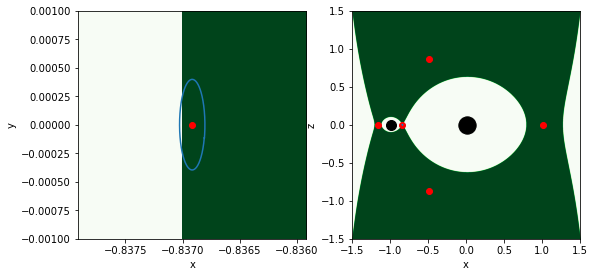

In [16]:
# We plot the initial condition (zoom in the Lagrangian point)
plt.figure(figsize=(9,9))

plt.subplot(1,2,1)
plt.plot(out[4][:, 0], out[4][:, 1])
plt.xlabel("x")
plt.ylabel("y")

# Plot the zero velocity curve
xx = np.linspace(-1.5,1.5,2000)
yy = np.linspace(-1.5,1.5,2000)
x_grid,y_grid = np.meshgrid(xx,yy)
im = plt.imshow( ((potential_function((x_grid,y_grid,np.zeros(np.shape(x_grid))),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),y_grid.min(),y_grid.max()),origin="lower", cmap="Greens")

# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=100)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, yL45, c='r')
plt.scatter(-0.5+mu, -yL45, c='r')


plt.xlim(xL1-0.001, xL1+0.001)
plt.ylim(-0.001, +0.001)

plt.subplot(1,2,2)
plt.plot(out[4][:, 0], out[4][:, 2])
plt.xlabel("x")
plt.ylabel("z")

# Plot the zero velocity curve
xx = np.linspace(-1.5,1.5,2000)
zz = np.linspace(-1.5,1.5,2000)
x_grid,z_grid = np.meshgrid(xx,zz)
im = plt.imshow( ((potential_function((x_grid,np.zeros(np.shape(x_grid)), z_grid),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),y_grid.min(),y_grid.max()),origin="lower", cmap="Greens")

# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=100)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, yL45, c='r')
plt.scatter(-0.5+mu, -yL45, c='r')